In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('dark')
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Pre-wrangled data
data = pd.read_csv('data_factor_analysis.csv')
data = data[[i for i in data.columns if 'Unnamed' not in i]] # fix import bug

data.shape

(87, 512)

In [3]:
data.head()

,iacceptpeopleastheyare,iaccomplishmyworkontime,iactattheexpenseofothers,iactcomfortablywithothers,iactwildandcrazy,iadapteasilytonewsituations,ialwaysknowwhatiamdoing,iamacreatureofhabit,iamapersonwhosemoodsgoupanddowneasily,iamaveryprivateperson,...,iwarmupquicklytoothers,iwastemytime,iwearmyheartonmysleeve,iwilldoanythingforothers,iwillnotprobedeeplyintoasubject,iworkaccordingtoaroutine,iworkonimprovingmyself,iworryaboutthings,iwouldnevercheatonmytaxes,iwouldntharmafly
0,6,5,1,6,1,3,1,6,4,6,...,5,6,6,6,1,5,7,7,7,2
1,2,7,1,4,5,6,5,5,6,2,...,7,3,5,5,1,6,7,6,7,7
2,6,6,4,6,3,5,3,5,6,6,...,5,4,3,4,2,6,6,6,4,1
3,7,7,2,4,3,4,4,7,2,4,...,4,3,5,4,4,6,7,6,7,2
4,7,6,1,5,4,5,5,4,1,5,...,1,4,1,1,3,7,7,4,7,1


First we need to determine the appropriate number of factors. I propose doing this by taking the value of the **4th-smallest factor loading**.

Why 4th? Guadagnoli & Velicer (1988) consider a factor to be reliable if it has 4 or more loadings of at least 0.6, regardless of the sample size.

Meanwhile, MacCallum et al. (1999, 2001) assert that I should use a minimum value of 0.65, considering my sample size. (See http://imaging.mrc-cbu.cam.ac.uk/statswiki/FAQ/thresholds for more tips)

So let's see how many factors have a minimum loading of at least 0.65.

In [4]:
from sklearn.decomposition import FactorAnalysis

print('Minimum factor loadings for n factors:\n')

for n_comp in range(1,11):
    print(n_comp, end=': ')
    fa = FactorAnalysis(n_components=n_comp).fit(data)
    fa1 = fa.transform(data)

    # Stick it in a dataframe
    factors = pd.DataFrame(fa.components_, columns=data.columns).T
    
    # Record and compare minimum factor loadings
    mins = []
    for i in factors.columns:
        factors['absol'] = abs(factors[i])
        factors_sorted = factors.sort_values('absol', ascending=False).head(4) # Top 4
        mins.append(factors_sorted['absol'].min())                              # Min value
        del factors['absol']
    
    print(np.min(np.array(mins)))

Minimum factor loadings for n factors:

1: 0.944955920789
2: 0.830944261965
3: 0.951757025915
4: 0.872761764139
5: 0.852148928373
6: 0.680648152505
7: 0.659478015434
8: 0.563884395949
9: 0.564597438258
10: 0.567227763139


Notice that we find less and less variability as we add more factors! For machine learning, there isn't much harm in using too many factors, but in psychometrics, we need to follow the rule outlined above.

7 appears to be a good number for this dataset. Let's take a look at what constitutes each factor.

1
Axes(0.125,0.125;0.775x0.755)


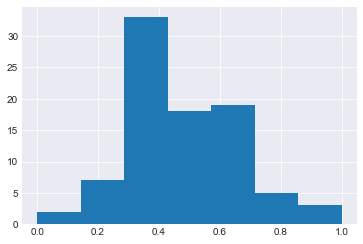

2
Axes(0.125,0.125;0.775x0.755)


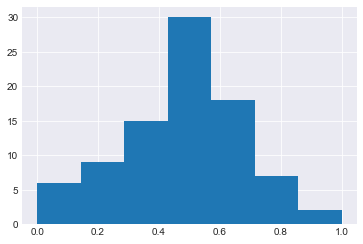

3
Axes(0.125,0.125;0.775x0.755)


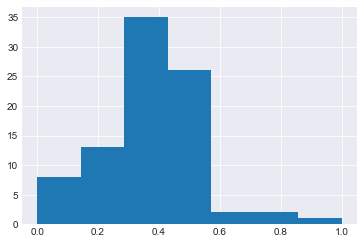

4
Axes(0.125,0.125;0.775x0.755)


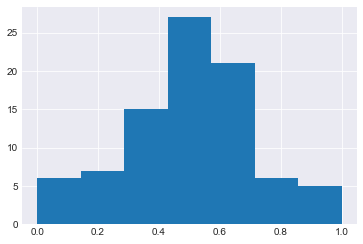

5
Axes(0.125,0.125;0.775x0.755)


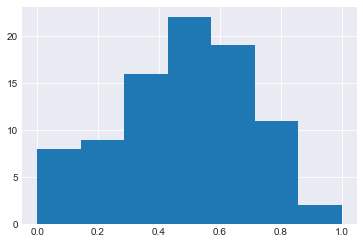

6
Axes(0.125,0.125;0.775x0.755)


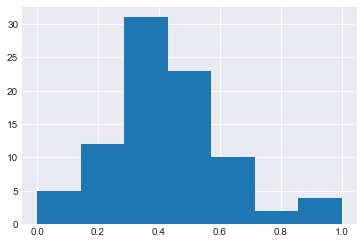

7
Axes(0.125,0.125;0.775x0.755)


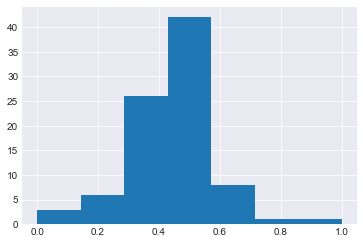

In [5]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import MinMaxScaler

n_comp = 7

fa = FactorAnalysis(n_components=n_comp).fit(data)
factors = fa.transform(data)

# Scale values
mms = MinMaxScaler().fit(factors)
factors = mms.transform(factors)

factors = pd.DataFrame(factors, columns=[str(n) for n in np.arange(1,n_comp+1,1)])

# Let's look at the histograms as well...
for i in factors.columns:
    print(i)
    print(factors[i].hist(bins=7))
    plt.show()

Those are some nice-looking distributions!

Now let's examine which items correlate with each factor.

In [6]:
def show_items(factor):
    '''Returns a dataframe of correlations, sorted
    by absolute value'''
    f = pd.DataFrame(data.corrwith(factors[str(factor)]))
    f['absol'] = abs(f[0])
    return f.sort_values('absol', ascending=False).drop('absol', axis=1).head()

# This is like a mixture of extraversion and assertiveness
show_items(1)

,0
ihandletaskssmoothly,0.681
itakecharge,0.664
iturnplansintoactions,0.663
icaneasilypushmyselfforward,0.611
iexcelinwhatido,0.602


In [7]:
# Neuroticism and sensitivity to stress
show_items(2)

,0
iworryaboutthings,-0.714
igetoverwhelmedbyemotions,-0.670
igetstressedouteasily,-0.650
iameasilyhurt,-0.593
iwanteverydetailtakencareof,-0.573


In [8]:
# (Dis)agreeableness
show_items(3)

,0
imakedemandsonothers,0.688
igetangryeasily,0.628
ithinktoohighlyofmyself,0.625
ireactintensely,0.590
isnapatpeople,0.583


In [9]:
# I'd call this one extraversion "proper"
show_items(4)

,0
iprefertobealone,0.560
iseekquiet,0.551
iameasilyexcited,-0.536
ishowmyfeelings,-0.533
iamopenaboutmyfeelings,-0.514


In [10]:
# Openness to experience
show_items(5)

,0
idonotlikeart,0.533
iexperienceveryfewemotionalhighsandlows,0.516
iseldomnoticetheemotionalaspectsofpaintingsandpictures,0.512
idonotlikepoetry,0.509
ibelieveintheimportanceofart,-0.503


In [11]:
# I guess I'd call this... inattentiveness?
# (This makes me think we still need more data -- these shouldn't correlate together so much)
show_items(6)

,0
ifrequentlyforgettodothings,0.540
iletmyattentionwanderoff,0.462
ispendtimereflectingonthings,0.455
ienjoycrudejokes,0.439
itrytounderstandmyself,0.437


In [12]:
# Self-confidence, or something vaguely like it.
show_items(7)

,0
iwanttobetoldiamright,-0.448
ionlytalkaboutmyowninterests,-0.426
iamfilledwithdoubtsaboutthings,-0.407
ifeelcomfortablewithmyself,0.384
iseekquiet,0.371
